# Including nesseccery libraries:
---

In [1]:
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import time
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,log_loss

# Data loading:
---

In [2]:
covid_hate = pd.read_csv('COVID-hate.csv')

In [3]:
covid_hate.head()

,Tweet ID,Text,label
0,1242553623260868608,Are we still allowed to quote ancient Chinese ...,0
1,1246508137638580225,@mamacat2u @VBeltiz More power to you! This C...,0
2,1233468243534372865,"CNBC: WHO, Tedros reiterated that the virus co...",0
3,1243626072387747841,"""The heightened racism experienced by Asian co...",1
4,1225611530978217989,Coronavirus and Nepali in China: KP Oli has di...,0


In [4]:
covid_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet ID  2290 non-null   int64 
 1   Text      2290 non-null   object
 2   label     2290 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.8+ KB


# Data preprocessing:
---

In [5]:
print(covid_hate['Text'].iloc[0],"\n")
print(covid_hate['Text'].iloc[1],"\n")
print(covid_hate['Text'].iloc[2],"\n")
print(covid_hate['Text'].iloc[3],"\n")
print(covid_hate['Text'].iloc[4],"\n")

Are we still allowed to quote ancient Chinese proverbs, or is that racist? #RacismIsAVirus 

@mamacat2u @VBeltiz More power to you!  This Chinese virus thing have really shown us who are the crazies and low IQ people are.  I went to Sam's Club and Costco this morning and both stores had lines that wrapped around the building to get inside.  Fuck that! I left disappointed at humanity. 

CNBC: WHO, Tedros reiterated that the virus could still turn into a pandemic. He urged against fear and panic, adding, "our greatest enemy right now is not the virus itself. It's fear, rumors and stigma." https://t.co/jOVYmu072D  via @GoogleNews 

"The heightened racism experienced by Asian communities is surprising to many people because beliefs in racial progress are widespread in American society." @YaleSOM's @mwkraus and @EuniceHEun https://t.co/wUW45bCyp5 #COVID19 #RacismIsAVirus #StrongerTogether #AsianAmericans 

Coronavirus and Nepali in China: KP Oli has directed officials to bring back Nepali i

In [6]:
 def data_preprocessing(data):
    # Initialize the lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Convert to lowercase
    data = data.lower()
    
    # Remove non-alphabetic characters
    data = re.sub(r'[^a-zA-Z\s]', '', data)
    
    # Remove extra spaces
    data = re.sub(r'\s+', ' ', data).strip()
    
    # Tokenize the data
    data_tokens = word_tokenize(data)
    
    # Lemmatize and remove stop words
    filtered_data = [lemmatizer.lemmatize(w) for w in data_tokens if w not in stop_words]
    
    # Return the processed data as a single string
    return " ".join(filtered_data)

In [7]:
covid_hate.Text = covid_hate['Text'].apply(data_preprocessing)

In [8]:
covid_hate = covid_hate.drop_duplicates('Text')

In [9]:
print(covid_hate['Text'].iloc[0],"\n")
print(covid_hate['Text'].iloc[1],"\n")
print(covid_hate['Text'].iloc[2],"\n")
print(covid_hate['Text'].iloc[3],"\n")
print(covid_hate['Text'].iloc[4],"\n")

still allowed quote ancient chinese proverb racist racismisavirus 

mamacatu vbeltiz power chinese virus thing really shown u crazy low iq people went sam club costco morning store line wrapped around building get inside fuck left disappointed humanity 

cnbc tedros reiterated virus could still turn pandemic urged fear panic adding greatest enemy right virus fear rumor stigma httpstcojovymud via googlenews 

heightened racism experienced asian community surprising many people belief racial progress widespread american society yalesoms mwkraus euniceheun httpstcowuwbcyp covid racismisavirus strongertogether asianamericans 

coronavirus nepali china kp oli directed official bring back nepali wuhan china keep httpstcouhiewvyz 



# Data Visualizing:

In [10]:
covid_hate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 0 to 2289
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet ID  2199 non-null   int64 
 1   Text      2199 non-null   object
 2   label     2199 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 68.7+ KB


In [11]:
covid_hate['label'].value_counts()

label
0    1314
1     461
2     424
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

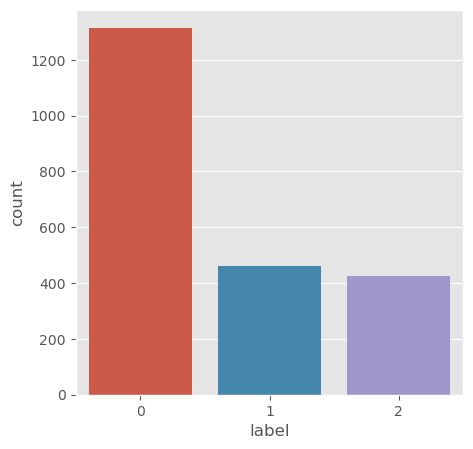

In [12]:
fig = plt.figure(figsize = (5,5))
sns.countplot(x = 'label',data = covid_hate)

In [13]:
covid_hate = covid_hate[covid_hate['label'] != 2]

Text(0.5, 1.0, 'Distribution of Labels')

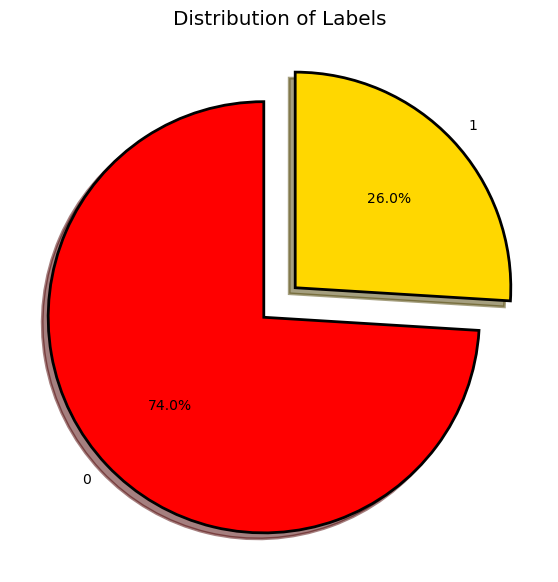

In [14]:
fig = plt.figure(figsize = (7,7))
colors = ("red","gold")
wp = {'linewidth' : 2,'edgecolor':"black"}
tags = covid_hate['label'].value_counts()
explode = (0.1,0.1)
tags.plot(kind = 'pie',autopct = '%1.1f%%',shadow = True,colors = colors,startangle = 90,
         wedgeprops = wp,explode = explode,label = '')
plt.title('Distribution of Labels')

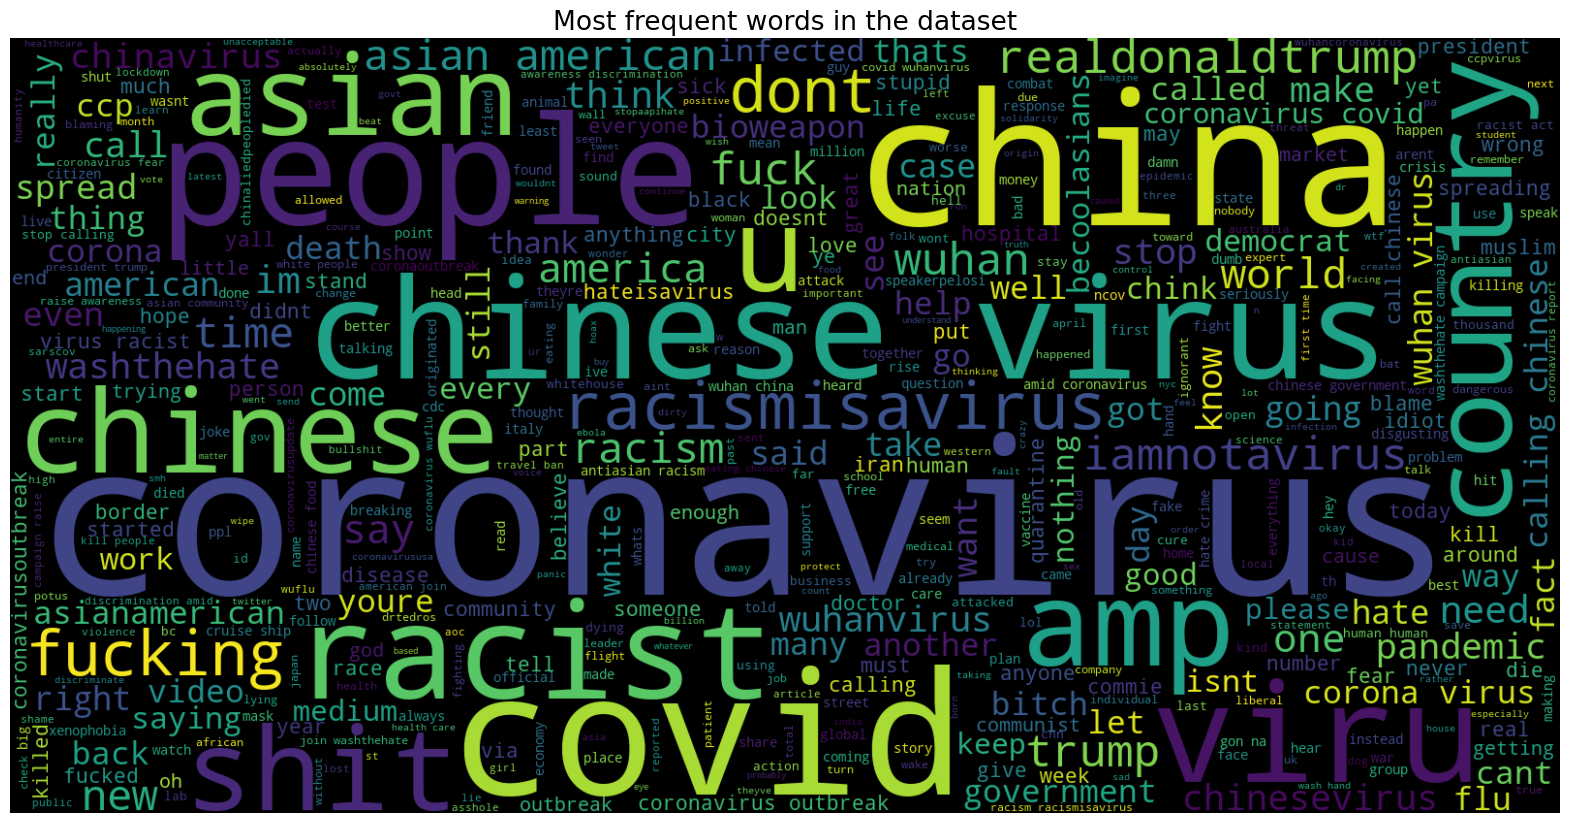

In [15]:
text = ' '.join([word for word in covid_hate['Text']])
plt.figure(figsize = (20,15),facecolor = 'None')
wordcloud = WordCloud(max_words = 500,width = 1600,height= 800).generate(text)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title('Most frequent words in the dataset',fontsize = 19)
plt.show()

# Vectorization:

In [16]:
vect = TfidfVectorizer(ngram_range = (1,2)).fit(covid_hate['Text'])

In [17]:
feature_names = vect.get_feature_names_out()

In [18]:
vect = TfidfVectorizer(ngram_range = (1,3)).fit(covid_hate['Text'])

In [19]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 fetures: \n{}".format(feature_names[:20]))

Number of features: 52793

First 20 fetures: 
['aaaaaaaaahhhhhhh' 'aaaaaaaaahhhhhhh going' 'aaaaaaaaahhhhhhh going die'
 'aac' 'aac cancel' 'aac cancel tournament' 'aaccstatement'
 'aaccstatement asianamericans' 'aaccstatement asianamericans solidarity'
 'aaccstatement iamnotavirus' 'aaccstatement iamnotavirus racismisavirus'
 'aajtak' 'aajtak india' 'aajtak india today' 'aap' 'aap bhi'
 'aap bhi band' 'aapi' 'aapi community' 'aapi community covid']


# Train-Test split 

In [20]:
x = covid_hate['Text']
y = covid_hate['label']
X = vect.transform(x);

In [55]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (60%) and combined validation+test set (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split the combined validation+test set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1065
Validation set size: 355
Test set size: 355


# logistic Regression Model

In [22]:
model = LogisticRegression()
model.fit(X_train,y_train)
model_train = model.predict(X_train)
model_pred = model.predict(X_val)
model_train_acc = accuracy_score(model_train,y_train)
model_acc = accuracy_score(model_pred,y_val)
print("Train accuracy: {:.2f}%".format(model_train_acc*100))
print("Validation accuracy: {:.2f}%".format(model_acc*100))

Train accuracy: 82.44%
Validation accuracy: 78.03%


In [23]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [58]:
#Define the parameter grid for GridSearchCV
param_grid = {'C': [500, 10, 1.0, 0.1, 0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

#Create the GridSearchCV object
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)

#Measure training time
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
training_time1 = end_time - start_time

#Best model after grid search
best_model = grid.best_estimator_

#Measure inference time on a subset of the test data
sample_size = 355  # You can adjust this size based on your requirements
sample_x_test = X_test[:sample_size]

start_inference_time = time.time()
_ = best_model.predict(sample_x_test)
end_inference_time = time.time()
inference_time1 = end_inference_time - start_inference_time

# Training and validation accuracy
train_predictions = best_model.predict(X_train)
val_predictions = best_model.predict(X_val)

training_accuracy1 = accuracy_score(y_train, train_predictions)
validation_accuracy1 = accuracy_score(y_val, val_predictions)

# Training loss
train_proba = best_model.predict_proba(X_train)
training_loss1 = log_loss(y_train, train_proba)

# Model complexity (number of parameters)
num_parameters1 = best_model.coef_.size + best_model.intercept_.size

# Print results
print(f"Best Cross Validation score: {grid.best_score_:.2f}")
print(f"Best Parameters: {grid.best_params_}")
print(f"Training time: {training_time1:.2f} seconds")
print(f"Inference time on {sample_size} samples: {inference_time1:.2f} seconds")
print(f"Number of trainable parameters: {num_parameters1}")
print(f"Training loss: {training_loss1:.4f}")
print(f"Training accuracy: {training_accuracy1 * 100:.2f}%")
print(f"Validation accuracy: {validation_accuracy1 * 100:.2f}%")

Best Cross Validation score: 0.85
Best Parameters: {'C': 500, 'solver': 'lbfgs'}
Training time: 7.08 seconds
Inference time on 355 samples: 0.00 seconds
Number of trainable parameters: 52794
Training loss: 0.0046
Training accuracy: 100.00%
Validation accuracy: 89.01%


<Figure size 1000x700 with 0 Axes>

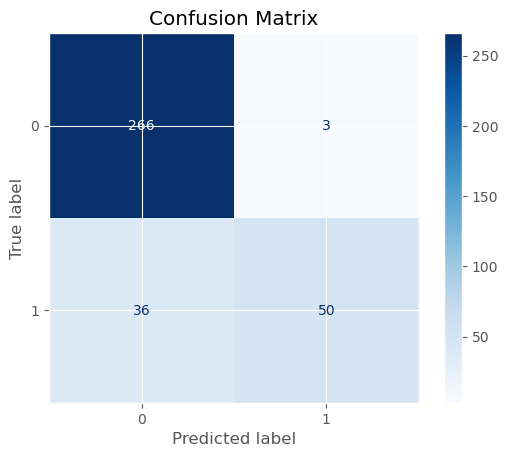

In [26]:
# Get predictions for the validation set using the best model
y_pred = best_model.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=best_model.classes_)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Random Forest Model:


In [27]:
# Initialize the RandomForestClassifier with the specified parameters
rf_model = RandomForestClassifier(max_depth=150, n_estimators=19, random_state=10)

# Measure training time
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
training_time2 = end_time - start_time

# Measure inference time on a subset of the test data
sample_size = 355 
sample_x_val = X_val[:sample_size]

start_inference_time = time.time()
_ = rf_model.predict(sample_x_test)
end_inference_time = time.time()
inference_time2 = end_inference_time - start_inference_time

# Training accuracy
rf_model_train = rf_model.predict(X_train)
training_accuracy2 = accuracy_score(y_train, rf_model_train)

# Validation accuracy
rf_model_val = rf_model.predict(X_val)
validation_accuracy2 = accuracy_score(y_val, rf_model_val)

# Training loss
train_proba = rf_model.predict_proba(X_train)
training_loss2 = log_loss(y_train, train_proba)

# Model complexity (number of parameters)
# For RandomForest, model complexity can be estimated by the number of trees and their depth.
num_trees = len(rf_model.estimators_)
average_depth = np.mean([tree.tree_.max_depth for tree in rf_model.estimators_])
model_complexity = f"Number of trees: {num_trees}, Average tree depth: {average_depth:.2f}"

# Print results
print(f"Training time: {training_time2:.2f} seconds")
print(f"Inference time on {sample_size} samples: {inference_time2:.2f} seconds")
print(f"Model complexity: {model_complexity}")
print(f"Training loss: {training_loss2:.4f}")
print(f"Training accuracy: {training_accuracy2 * 100:.2f}%")
print(f"Validation accuracy: {validation_accuracy2 * 100:.2f}%")

Training time: 0.80 seconds
Inference time on 355 samples: 0.01 seconds
Model complexity: Number of trees: 19, Average tree depth: 122.37
Training loss: 0.0747
Training accuracy: 99.81%
Validation accuracy: 88.17%


<Figure size 1000x700 with 0 Axes>

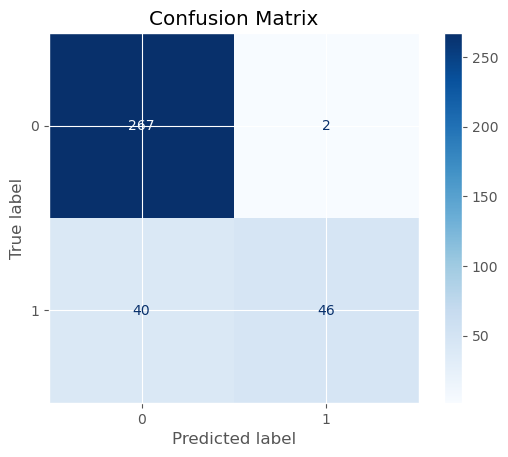

In [28]:
# Compute confusion matrix
y_pred = rf_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

# Create and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Neural Network

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Define the model
model2 = Sequential([
    Dense(256, activation='relu', name='L1', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', name='L2', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', name='L3', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', name='L4', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax', name='Output')
])

# Compile the model
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Measure training time
start_time = time.time()
history = model2.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
end_time = time.time()
training_time3 = end_time - start_time

# Measure inference time on a subset of the test data
sample_size = 355  # You can adjust this size based on your requirements
sample_x_val = X_val[:sample_size]

start_inference_time = time.time()
_ = model2.predict(sample_x_val)
end_inference_time = time.time()
inference_time3 = end_inference_time - start_inference_time

# Get model complexity (number of trainable parameters)
num_parameters = model2.count_params()

# Evaluate the model on training and validation data
train_loss3, train_accuracy3 = model2.evaluate(X_train, y_train, verbose=0)
val_loss3, val_accuracy3 = model2.evaluate(X_val, y_val, verbose=0)

# Print the results
print(f"Training time: {training_time3:.2f} seconds")
print(f"Inference time on {sample_size} samples: {inference_time3:.2f} seconds")
print(f"Number of trainable parameters: {num_parameters}")
print(f"Training loss: {train_loss3:.4f}")
print(f"Training accuracy: {train_accuracy3 * 100:.2f}%")
print(f"Validation loss: {val_loss3:.4f}")
print(f"Validation accuracy: {val_accuracy3 * 100:.2f}%")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7150 - loss: 1.1264 - val_accuracy: 0.7042 - val_loss: 0.8117
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7342 - loss: 0.6825 - val_accuracy: 0.7042 - val_loss: 0.6463
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7927 - loss: 0.4138 - val_accuracy: 0.8404 - val_loss: 0.6135
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9996 - loss: 0.2596 - val_accuracy: 0.8592 - val_loss: 0.6070
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 0.1444 - val_accuracy: 0.8498 - val_loss: 0.6854
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9941 - loss: 0.1390 - val_accuracy: 0.8638 - val_loss: 0.6019
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 0.1324 - val_accuracy: 0.8498 - val_loss: 0.7037
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9974 - loss: 0.1263 - val_accu

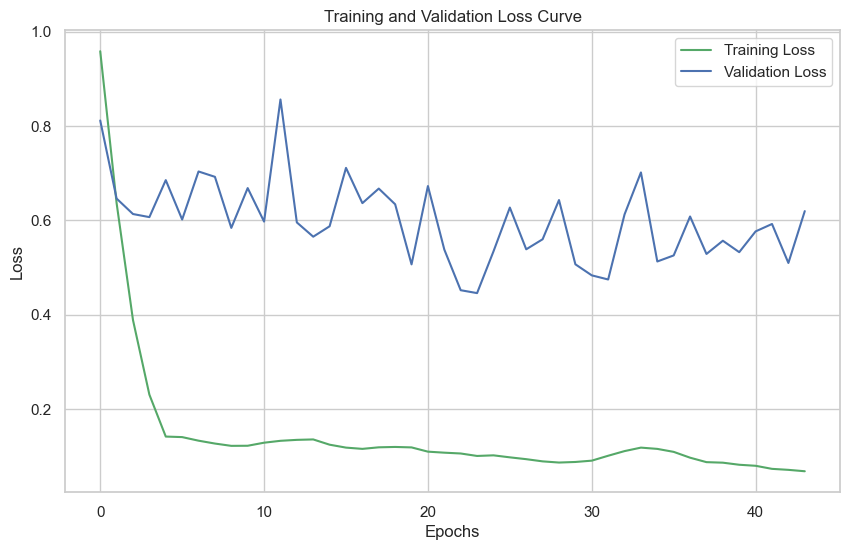

In [64]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot both training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='g')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<Figure size 1000x700 with 0 Axes>

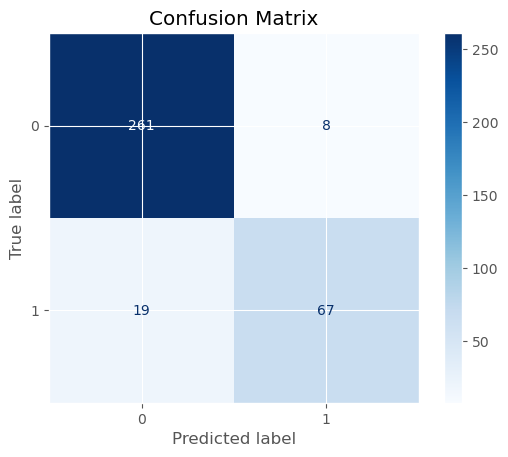

In [32]:
# Make predictions on the validation data
y_pred = np.argmax(model2.predict(X_val), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosting Classifier

In [33]:
import time
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Measure training time
start_time = time.time()

# Fit the model on the training data
gb_model.fit(X_train, y_train)

# Calculate training time
training_time4 = time.time() - start_time

# Predict on the training set
gb_train_pred = gb_model.predict(X_train)
gb_train_pred_proba = gb_model.predict_proba(X_train)

# Predict on the validation/test set
gb_test_pred = gb_model.predict(X_val)
gb_test_pred_proba = gb_model.predict_proba(X_val)

# Calculate accuracy for training and validation/test sets
gb_train_acc4 = accuracy_score(y_train, gb_train_pred)
gb_test_acc4 = accuracy_score(y_val, gb_test_pred)

# Calculate log loss (cross-entropy loss) for training and validation/test sets
gb_train_loss4 = log_loss(y_train, gb_train_pred_proba)
gb_test_loss4 = log_loss(y_val, gb_test_pred_proba)

# Calculate the number of trainable parameters
# This calculation is based on the number of estimators and the depth of each tree.
num_estimators = gb_model.n_estimators
# Each tree in GradientBoostingClassifier typically has several nodes,
# but counting exact parameters is non-trivial. You can approximate or ignore for practical purposes.

# Measure inference time
start_time_inference = time.time()
_ = gb_model.predict(X_val)  # Or use X_train if you want to measure on training set
inference_time4 = time.time() - start_time_inference

# Print results
print("GB Train accuracy: {:.2f}%".format(gb_train_acc4 * 100))
print("GB Validation accuracy: {:.2f}%".format(gb_test_acc4 * 100))
print("GB Train loss: {:.4f}".format(gb_train_loss4))
print("GB Test loss: {:.4f}".format(gb_test_loss4))
print("Training time: {:.4f} seconds".format(training_time4))
print("Inference time: {:.4f} seconds".format(inference_time4))
print("Number of estimators: {}".format(num_estimators))

GB Train accuracy: 95.77%
GB Test accuracy: 91.27%
GB Train loss: 0.1470
GB Test loss: 0.2410
Training time: 16.0867 seconds
Inference time: 0.0010 seconds
Number of estimators: 100


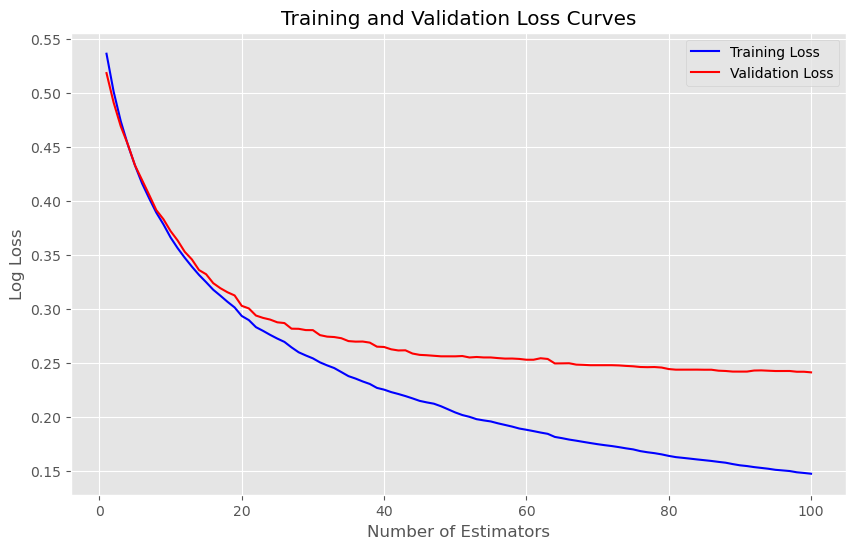

In [36]:
# Prepare lists to store losses
train_losses = []
val_losses = []

# Compute losses for each stage
for stage in gb_model.staged_predict_proba(X_train):
    train_losses.append(log_loss(y_train, stage))

for stage in gb_model.staged_predict_proba(X_val):
    val_losses.append(log_loss(y_val, stage))

# Plotting the loss curves
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')

# Plot validation loss
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')

plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

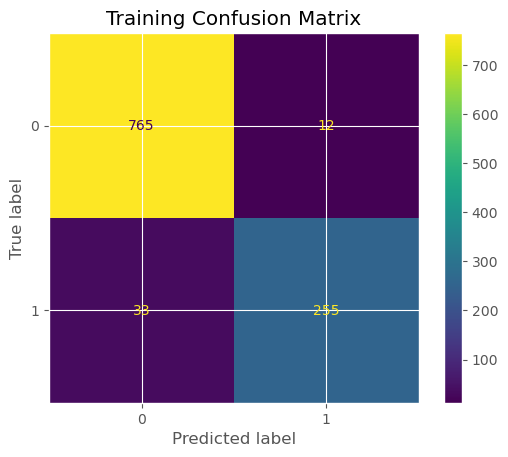

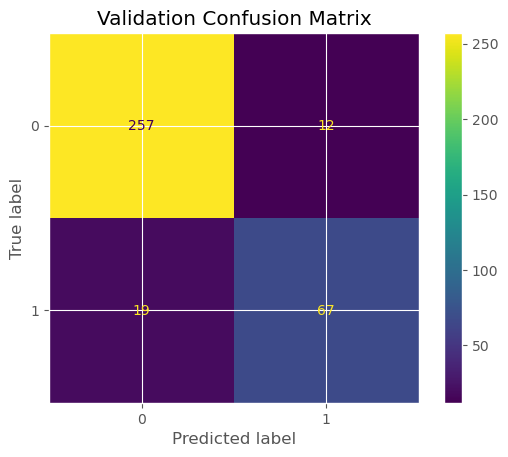

In [38]:
train_conf_matrix = confusion_matrix(y_train, gb_train_pred)
ConfusionMatrixDisplay(train_conf_matrix).plot()
plt.title("Training Confusion Matrix")
plt.show()

val_conf_matrix = confusion_matrix(y_val, gb_test_pred)
ConfusionMatrixDisplay(val_conf_matrix).plot()
plt.title("Validation Confusion Matrix")
plt.show()

# Neural Network + MHA

In [39]:
import time
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, Add, Flatten, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Define the input shape based on your TF-IDF vectors
input_shape = X_train.shape[1]

# Create a functional model to integrate MHA with increased regularization and dropout
input_layer = Input(shape=(input_shape,))
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

x = Reshape((4, 8))(x)  # Reshape for MultiHeadAttention layer

# Add the Multi-Head Attention layer with fewer heads
mha_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
mha_output = LayerNormalization(epsilon=1e-6)(mha_output)
mha_output = Add()([x, mha_output])

# Flatten the output of the MHA layer before passing it to Dense layers
flattened_output = Flatten()(mha_output)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flattened_output)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

output_layer = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

# Early stopping with reduced patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Measure training time
start_time = time.time()
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
end_time = time.time()
training_time5 = end_time - start_time

# Measure inference time on the validation data
start_inference_time = time.time()
Val_predictions = model.predict(X_val)
end_inference_time = time.time()
inference_time5 = end_inference_time - start_inference_time

# Calculate training accuracy
train_predictions = model.predict(X_train)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_accuracy5 = accuracy_score(y_train, train_pred_labels)

# Calculate validation accuracy
Val_pred_labels = np.argmax(Val_predictions, axis=1)
Val_accuracy5 = accuracy_score(y_val, Val_pred_labels)

# Get the number of trainable parameters
num_parameters = model.count_params()

# Get the final training and validation loss from history
training_loss5 = history.history['loss'][-1]
validation_loss5 = history.history['val_loss'][-1]

print(f'Training time: {training_time5:.2f} seconds')
print(f'Inference time on validation set: {inference_time5:.2f} seconds')
print(f'Number of trainable parameters: {num_parameters}')
print(f'Training loss: {training_loss5:.4f}')
print(f'Validation loss: {validation_loss5:.4f}')
print(f'Training accuracy: {train_accuracy5 * 100:.2f}%')
print(f'Validation accuracy: {Val_accuracy5 * 100:.2f}%')

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.4044 - loss: 9.3405 - val_accuracy: 0.7042 - val_loss: 8.0034
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.5662 - loss: 7.7865 - val_accuracy: 0.7042 - val_loss: 6.9554
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6075 - loss: 6.7985 - val_accuracy: 0.7042 - val_loss: 6.2587
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6243 - loss: 6.1810 - val_accuracy: 0.7042 - val_loss: 5.7788
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6046 - loss: 5.7440 - val_accuracy: 0.7042 - val_loss: 5.4472
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6199 - loss: 5.4193 - val_accuracy: 0.7042 - val_loss: 5.2186
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6378 - loss: 5.1966 - val_accuracy: 0.7042 - val_loss: 5.0521
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6518 - loss: 5.0221 - val_accu

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9921 - loss: 2.3966 - val_accuracy: 0.8028 - val_loss: 2.8225
Epoch 52/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9852 - loss: 2.3635 - val_accuracy: 0.8169 - val_loss: 2.7105
Epoch 53/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9835 - loss: 2.3307 - val_accuracy: 0.8216 - val_loss: 2.6794
Epoch 54/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9935 - loss: 2.2833 - val_accuracy: 0.8075 - val_loss: 2.7460
Epoch 55/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9896 - loss: 2.2523 - val_accuracy: 0.8498 - val_loss: 2.5854
Epoch 56/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9939 - loss: 2.2252 - val_accuracy: 0.8920 - val_loss: 2.4170
Epoch 57/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9933 - loss: 2.1887 - val_accuracy: 0.7934 - val_loss: 2.7729
Epoch 58/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9836 - loss: 2.1707 - val_accuracy:

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9971 - loss: 1.1501 - val_accuracy: 0.8357 - val_loss: 1.8762
Epoch 102/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9971 - loss: 1.1332 - val_accuracy: 0.9014 - val_loss: 1.4904
Epoch 103/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9996 - loss: 1.1159 - val_accuracy: 0.8779 - val_loss: 1.6458
Epoch 104/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9967 - loss: 1.1090 - val_accuracy: 0.8920 - val_loss: 1.5666
Epoch 105/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 1.0864 - val_accuracy: 0.8920 - val_loss: 1.5549
Epoch 106/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9977 - loss: 1.0794 - val_accuracy: 0.8920 - val_loss: 1.4875
Epoch 107/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9992 - loss: 1.0550 - val_accuracy: 0.8920 - val_loss: 1.5322
Epoch 108/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 1.0341 - val_ac

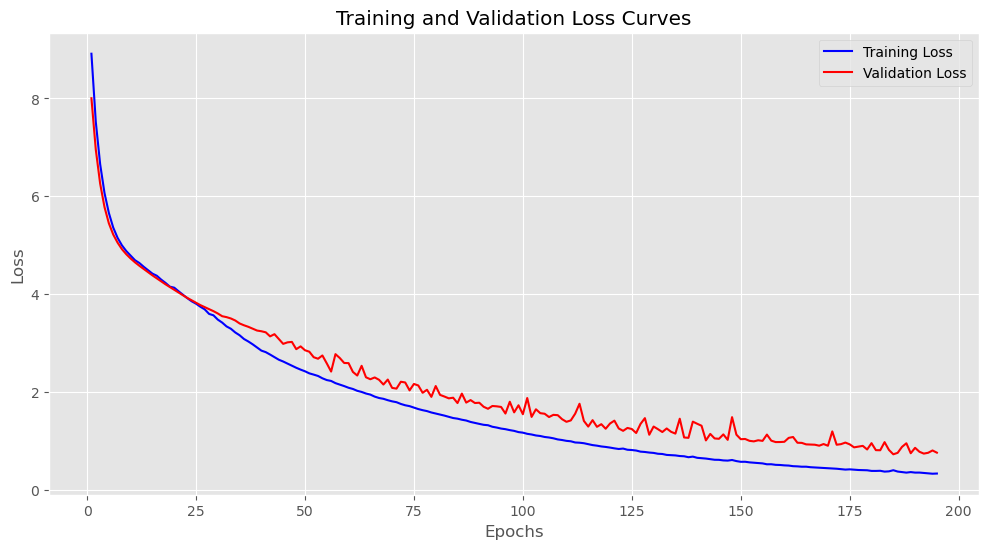

In [40]:
# Extract loss values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

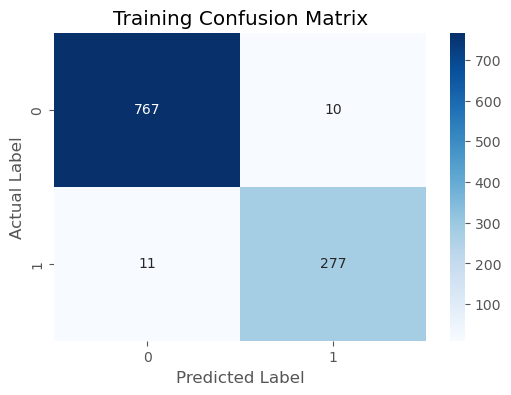

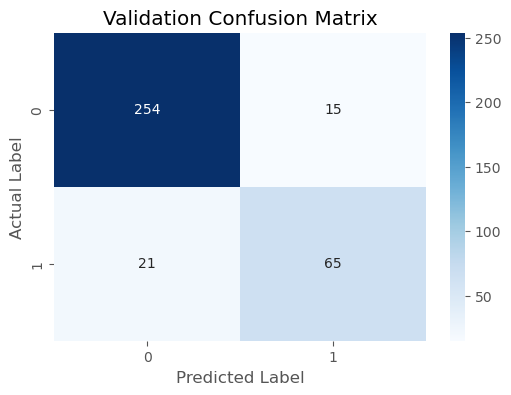

In [41]:
# Training confusion matrix
train_conf_matrix = confusion_matrix(y_train, train_pred_labels)

# Validation confusion matrix
val_conf_matrix = confusion_matrix(y_val, Val_pred_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(train_conf_matrix, 'Training Confusion Matrix')
plot_confusion_matrix(val_conf_matrix, 'Validation Confusion Matrix')

# Bert model

In [44]:
import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'covid_hate' is your DataFrame and 'Text' is your column with raw text data
x_train_raw = covid_hate['Text'].tolist()
x_test_raw = covid_hate['Text'].tolist()

# Extract labels from your dataset
y_train = covid_hate['label'].values  # Replace 'label' with your actual label column name
y_test = covid_hate['label'].values  # Replace 'label' with your actual label column name

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Tokenize and process text data in smaller batches to avoid high memory usage
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Use smaller batches to handle large datasets efficiently
def process_in_batches(texts, tokenizer, batch_size=32, max_length=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_tokens = tokenize_texts(batch_texts, tokenizer, max_length)
        batch_embeddings = get_bert_embeddings(batch_tokens, bert_model)
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis=0)

# Extract BERT embeddings
def get_bert_embeddings(tokens, model):
    outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
    return outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation

# Process data in batches
x_train_embeddings = process_in_batches(x_train_raw, tokenizer)
x_test_embeddings = process_in_batches(x_test_raw, tokenizer)

# Define MLP Model for Classification
input_shape = x_train_embeddings.shape[1]
input_layer = Input(shape=(input_shape,))
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

# Define the model
mlp_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
mlp_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(0.0001),  # Lower learning rate
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Measure training time
start_time = time.time()
history = mlp_model.fit(x_train_embeddings, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])
end_time = time.time()
training_time6 = end_time - start_time

# Measure inference time on the test data
start_inference_time = time.time()
test_loss, test_acc = mlp_model.evaluate(x_test_embeddings, y_test)
end_inference_time = time.time()
inference_time6 = end_inference_time - start_inference_time

# Manually predict labels for the test set (optional, but not necessary if using evaluate)
test_predictions = mlp_model.predict(x_test_embeddings)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_accuracy_manual = accuracy_score(y_test, test_pred_labels)

# Calculate training accuracy
train_predictions = mlp_model.predict(x_train_embeddings)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_accuracy6 = accuracy_score(y_train, train_pred_labels)

# Calculate validation accuracy (from history)
val_predictions = mlp_model.predict(x_train_embeddings[int(len(x_train_embeddings) * 0.8):])
val_pred_labels = np.argmax(val_predictions, axis=1)
y_val = y_train[int(len(y_train) * 0.8):]
val_accuracy6 = accuracy_score(y_val, val_pred_labels)

# Get the number of trainable parameters
num_parameters = mlp_model.count_params()

# Get the final training and validation loss from history
training_loss6 = history.history['loss'][-1]
validation_loss6 = history.history['val_loss'][-1]

# Print all the metrics
print(f'Training time: {training_time6:.2f} seconds')
print(f'Inference time on test set: {inference_time6:.2f} seconds')
print(f'Number of trainable parameters: {num_parameters}')
print(f'Training loss: {training_loss6:.4f}')
print(f'Validation loss: {validation_loss6:.4f}')
print(f'Training accuracy: {train_accuracy6 * 100:.2f}%')
print(f'Validation accuracy: {val_accuracy6 * 100:.2f}%')
print(f'Test accuracy (from evaluate): {test_acc * 100:.2f}%')
print(f'Test accuracy (manual calculation): {test_accuracy_manual * 100:.2f}%')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4526 - loss: 1.5777 - val_accuracy: 0.7268 - val_loss: 1.2404
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6974 - loss: 1.2715 - val_accuracy: 0.7268 - val_loss: 1.2028
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7099 - loss: 1.2320 - val_accuracy: 0.7268 - val_loss: 1.1674
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7391 - loss: 1.1785 - val_accuracy: 0.7268 - val_loss: 1.1374
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7369 - loss: 1.1655 - val_accuracy: 0.7268 - val_loss: 1.0921
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7609 - loss: 1.1038 - val_accuracy: 0.7775 - val_loss: 1.0558
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7720 - loss: 1.0657 - val_accuracy: 0.8028 - val_loss: 1.0014
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7625 - loss: 1.0722 - val_accuracy: 0.8028 - 

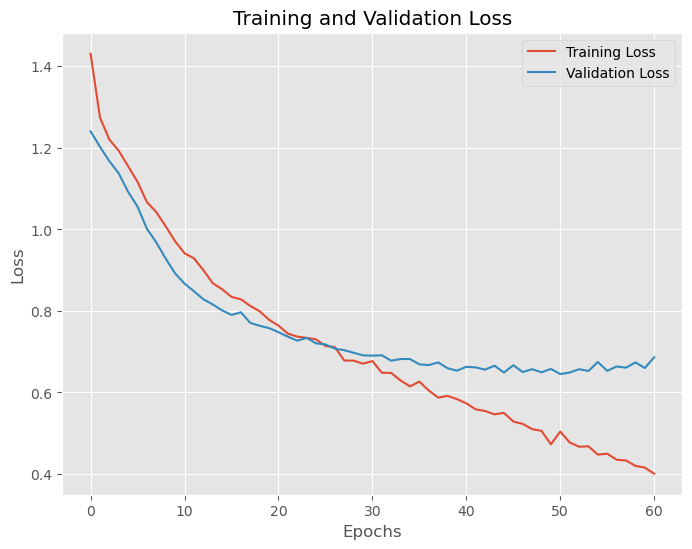

In [45]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


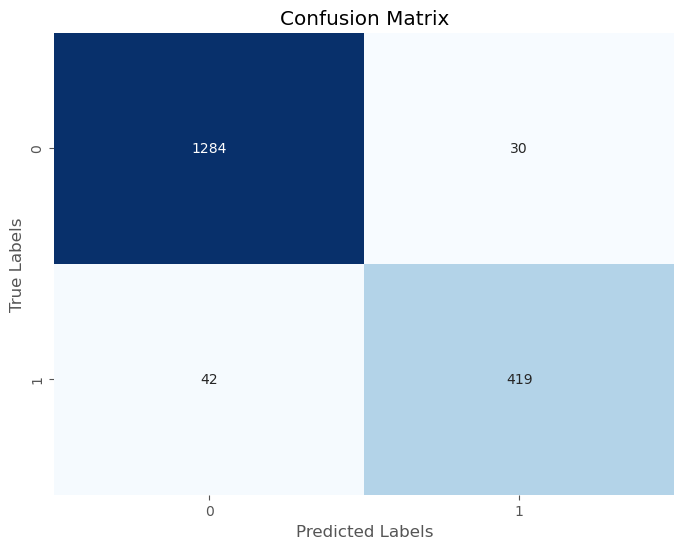

In [46]:
# Predict on the test set
y_test_pred = np.argmax(mlp_model.predict(x_test_embeddings), axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [52]:
# Create a dictionary to store model performance metrics
model_comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'Neural Network', 'Gradient Boosting', 'Neural Network+MHA', 'BERT'],
    'Training Accuracy': [training_accuracy1, training_accuracy2, train_accuracy3, gb_train_acc4, train_accuracy5, train_accuracy6],
    'Validation Accuracy': [validation_accuracy1, validation_accuracy2, val_accuracy3, gb_test_acc4, Val_accuracy5, test_acc],
    'Training Time (s)': [training_time1, training_time2, training_time3, training_time4, training_time5, training_time6],
    'Inference Time': [inference_time1, inference_time2, inference_time3, inference_time4, inference_time5, inference_time6]
}

# Create DataFrame
comparison_df = pd.DataFrame(model_comparison)

# Display the table
comparison_df

,Model,Training Accuracy,Validation Accuracy,Training Time (s),Inference Time
0,Logistic Regression,1.000000,0.890141,7.003660,0.000000
1,Random Forest,0.998122,0.881690,0.804233,0.008005
2,Neural Network,0.979343,0.923944,125.559378,0.402658
3,Gradient Boosting,0.957746,0.912676,16.086716,0.001000
4,Neural Network+MHA,0.980282,0.898592,576.139369,0.620839
5,BERT,0.959437,0.959437,17.502062,0.158536


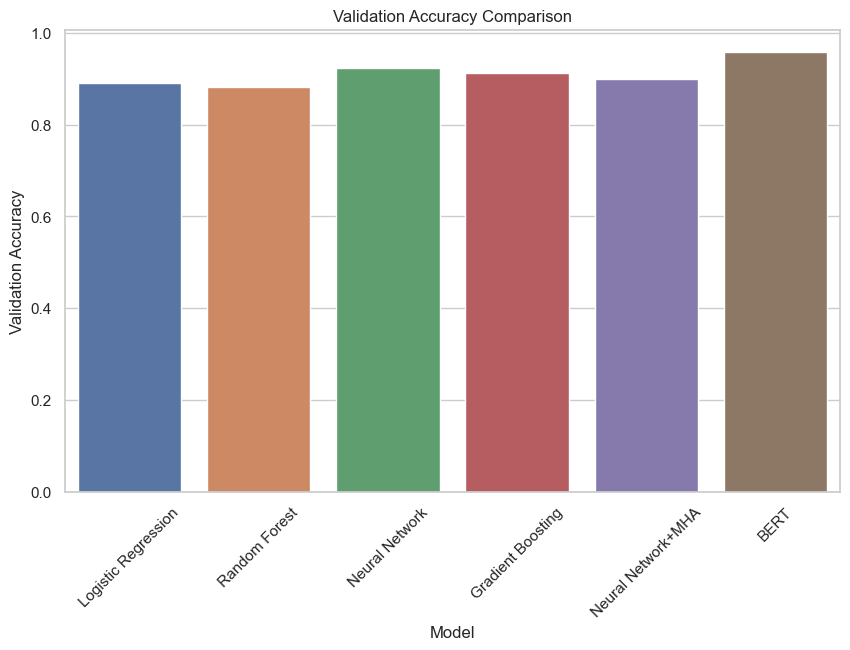

In [53]:
# Set style for the plot
sns.set(style="whitegrid")

# Plot comparison of validation accuracy for different models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation Accuracy', data=comparison_df)

plt.title('Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.show()